In [741]:
# --- IMPORTAÇÃO DAS BIBLIOTECAS ---

import numpy as np
import matplotlib.pyplot as plt

# Funções específicas do scikit-image
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.feature import canny

# Importações específicas para a Transformada de Hough (Detectar Círculos)
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

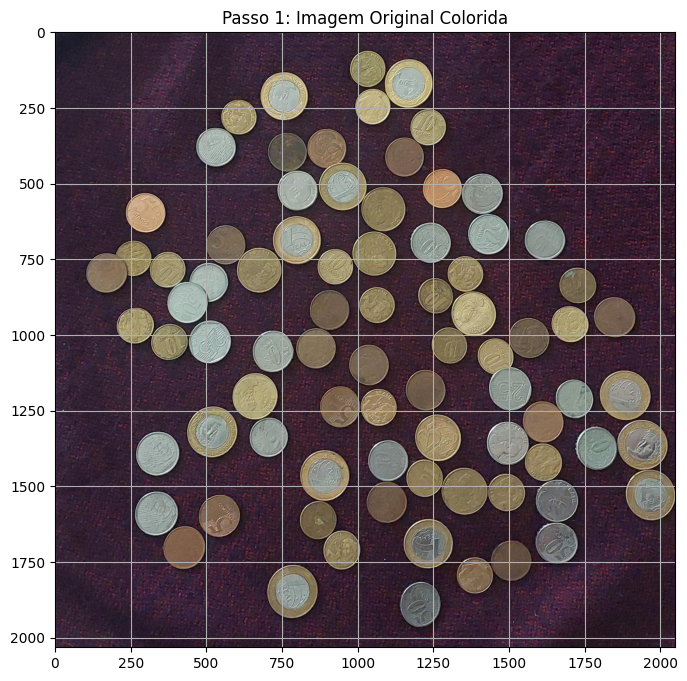

In [742]:
# --- CARREGAR A IMAGEM ---

caminho_arquivo = '../images/coin_04.jpg'

imagem_original = imread(caminho_arquivo)

plt.figure(figsize=(8, 8))
plt.imshow(imagem_original)
plt.title("Passo 1: Imagem Original Colorida")
plt.grid(True)
plt.show()

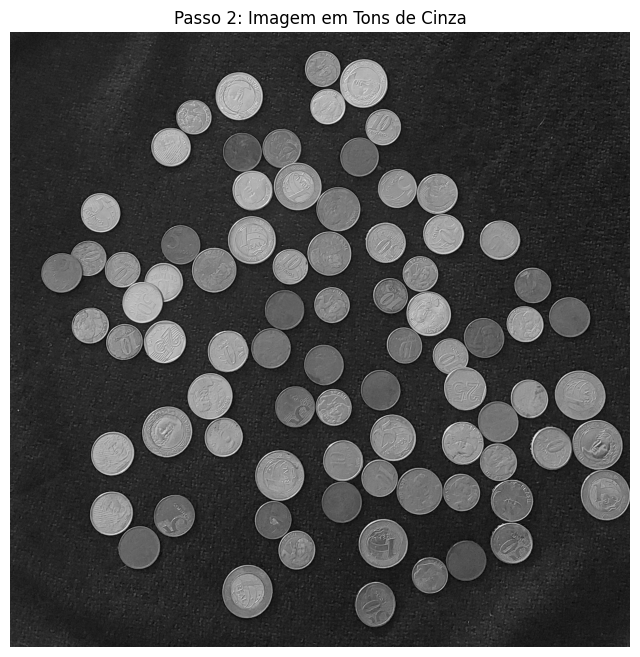

In [743]:
# --- CONVERSÃO PARA TONS DE CINZA ---

# A função rgb2gray converte a imagem para uma matriz 2D
# O resultado varia de 0.0 (preto absoluto) a 1.0 (branco absoluto)
imagem_cinza = rgb2gray(imagem_original)
imagem_cinza_uint8 = (imagem_cinza * 255).astype(np.uint8)

# Visualizando
plt.figure(figsize=(8, 8))
plt.imshow(imagem_cinza_uint8, cmap='gray')
plt.title("Passo 2: Imagem em Tons de Cinza")
plt.axis('off')
plt.show()

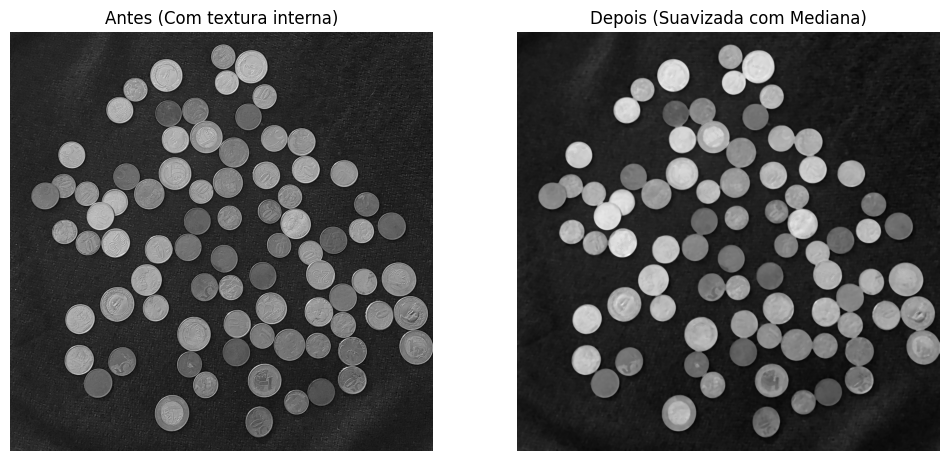

In [744]:
# --- FILTRAGEM DE RUÍDO (MEDIANA) ---

# Criamos um "elemento estruturante" em forma de disco.
# O número dentro do disk significa o tamanho do raio de um círculo em pixels.
# O filtro vai olhar vizinhanças desse tamanho e pegar o valor do meio (mediana).
elemento_disco = disk(7) 

# Aplicamos o filtro na imagem cinza
imagem_filtrada = median(imagem_cinza_uint8, elemento_disco)

# Visualizando a diferença
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(imagem_cinza_uint8, cmap='gray')
plt.title("Antes (Com textura interna)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagem_filtrada, cmap='gray')
plt.title("Depois (Suavizada com Mediana)")
plt.axis('off')

plt.show()

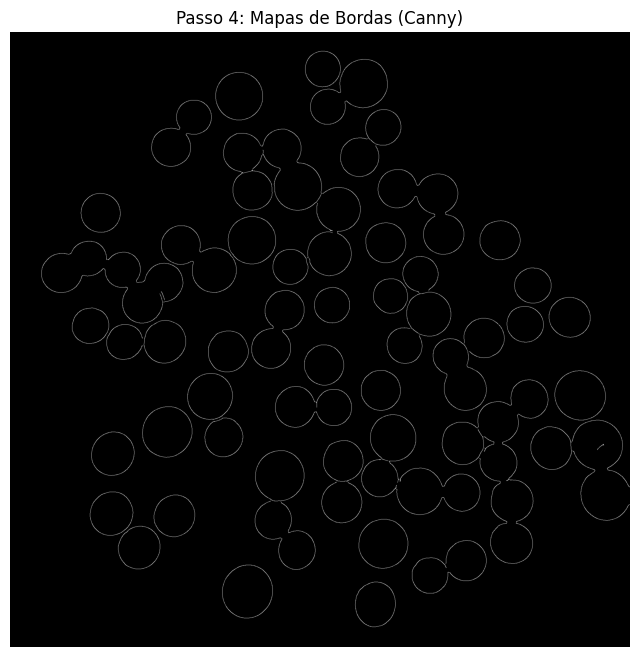

In [745]:
# --- DETECÇÃO DE BORDAS (CANNY) ---

# O parâmetro 'sigma' controla a suavização.
# sigma=3 é focado em pegar apenas contornos (as moedas).
# Se colocar sigma=1, ele pega qualquer risco.
bordas_canny = canny(imagem_filtrada, sigma=3)

# O resultado é uma imagem binária (True/False): True onde tem borda, False onde é liso.

# Visualizando
plt.figure(figsize=(8, 8))
# Mostramos em fundo preto (gray) onde o branco é a borda
plt.imshow(bordas_canny, cmap='gray') 
plt.title("Passo 4: Mapas de Bordas (Canny)")
plt.axis('off')
plt.show()

In [746]:
# --- TRANSFORMADA DE HOUGH (CALCULAR CENTROS) ---

# 1. Definir o que estamos procurando
# Aqui dizemos: "Procure círculos que tenham raio mínimo de 40px e máximo de 80px"
# O passo '2' significa que ele tenta 40, 42, 44...
raio_minimo = 30
raio_maximo = 250
passo_raio = 2
intervalo_raios = np.arange(raio_minimo, raio_maximo, passo_raio) 

print("Calculando acumulador de Hough (isso pode demorar um pouco)...")
# Essa função cria o espaço de votos
acumulador_hough = hough_circle(bordas_canny, intervalo_raios)

# 2. Achar os vencedores da votação (Os Picos)
# acumulador_hough: os votos
# intervalo_raios: os raios que testamos
# total_num_peaks: máximo de moedas que esperamos
accums, cx, cy, raios = hough_circle_peaks(acumulador_hough, intervalo_raios,
                                           total_num_peaks=100,
                                           min_xdistance=40, # Distância mínima entre centros (X)
                                           min_ydistance=40, # Distância mínima entre centros (Y)
                                           threshold=0.3 * np.max(acumulador_hough))
# Adicionamos o threshold=0.4 (40% da intensidade máxima encontrada)
# Isso descarta círculos "fracos"
print(f"Detectamos {len(raios)} círculos!")

if len(raios) > 0:
    # 1. Descobrir o tamanho da maior moeda encontrada
    maior_raio_encontrado = np.max(raios)
    
    # 2. Definir o corte (50% do tamanho da maior)
    # Moeda 1 Real = 27mm. Moeda 5 cent = 17mm. Relação = 0.63.
    # Usamos 0.5 (50%) como margem de segurança para erros de perspectiva.
    limite_aceitavel = maior_raio_encontrado * 0.5 

    print(f"Maior raio encontrado: {maior_raio_encontrado:.1f}px")
    print(f"Corte de segurança: Ignorando círculos menores que {limite_aceitavel:.1f}px")

    # 3. Criar uma 'máscara' (filtro)
    # Isso cria uma lista de Verdadeiro/Falso: [True, True, False, True...]
    filtro = raios >= limite_aceitavel

    # 4. Aplicar o filtro em todas as variáveis
    # Só mantém os índices onde o filtro é True
    cx = cx[filtro]
    cy = cy[filtro]
    raios = raios[filtro]
    accums = accums[filtro]

# O print final agora mostrará o número filtrado
print(f"Detectamos {len(raios)} círculos (após filtro de tamanho)!")

Calculando acumulador de Hough (isso pode demorar um pouco)...
Detectamos 81 círculos!
Maior raio encontrado: 86.0px
Corte de segurança: Ignorando círculos menores que 43.0px
Detectamos 81 círculos (após filtro de tamanho)!


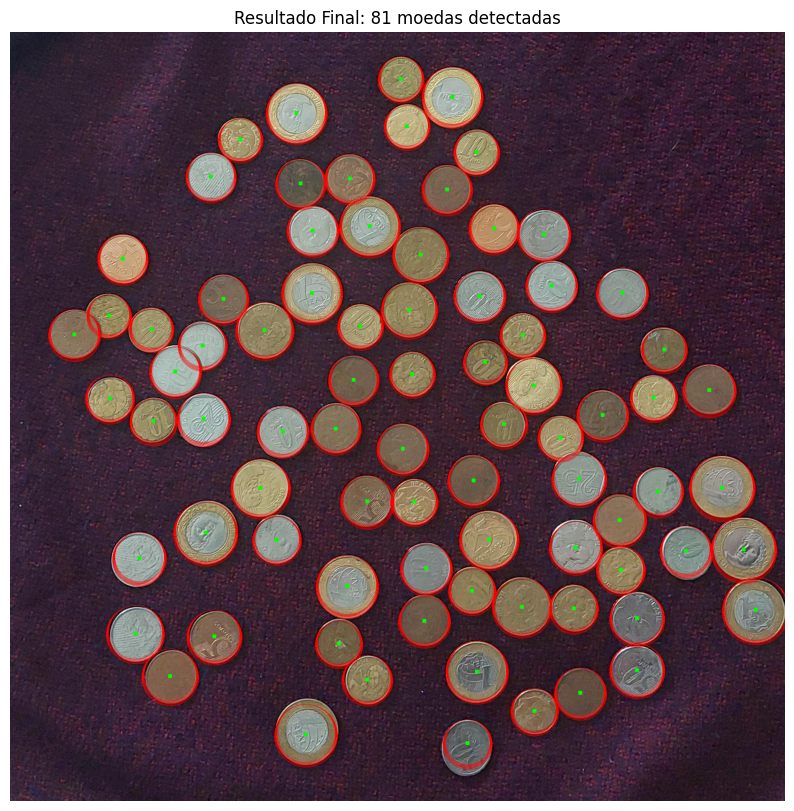

In [747]:
# --- DESENHANDO O RESULTADO ---

# Cria uma cópia da imagem original para não estragar a variável principal
imagem_resultado = np.copy(imagem_original)

# Loop para desenhar cada moeda encontrada
# zip(cy, cx, raios) junta as listas para processarmos uma moeda por vez
espessura = 3
for centro_y, centro_x, raio in zip(cy, cx, raios):
    for dr in range(-espessura, espessura + 1):
        # circle_perimeter devolve as coordenadas da BORDa do círculo
        circulo_y, circulo_x = circle_perimeter(
            centro_y + dr, centro_x, raio + dr,
            shape=imagem_original.shape
        )
        
        # Pintamos esses pixels de VERMELHO (R=255, G=0, B=0)
        imagem_resultado[circulo_y, circulo_x] = (255, 0, 0)
    
    # Dica extra: Vamos pintar o CENTRO também para ver se ele achou certo
    # Criamos um quadradinho 5x5 no centro
    imagem_resultado[centro_y-5:centro_y+5, centro_x-5:centro_x+5] = (0, 255, 0) # Verde

# Mostra final
plt.figure(figsize=(10, 10))
plt.imshow(imagem_resultado)
plt.title(f"Resultado Final: {len(raios)} moedas detectadas")
plt.axis('off')
plt.show()